In [1]:
import pandas as pd

metadata_df = pd.read_csv("/home/zhenhao/TDT/gtdb_utils/metadata_with_taxid.csv")

/tmp/ipykernel_9031/2215020646.py:3: DtypeWarning: Columns (62,64,66,75,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv("/home/zhenhao/TDT/gtdb_utils/metadata_with_taxid.csv")


In [2]:
import os

def extract_refseq_accession_from_genome_file_name(genome_file_name):
    basename = os.path.basename(genome_file_name)
    accession = "_".join(basename.split("_")[:2])
    return "RS_" + accession


def accession_to_species_name(accession, type="ncbi_genbank_assembly_accession", identifier="species_taxid"):
    """
    type is either "ncbi_genbank_assembly_accession" or "accession" (RefSeq accession).
    identifier is either "[species/genus/family]_taxid" or "[species/genus/family]_name"
    """
    sample_df = metadata_df[metadata_df[type] == accession]
    if len(sample_df) != 1:
        return None
    return sample_df.iloc[0][identifier]

In [3]:
file1 = "../../output/sylph_sensitivity_output/profile_merged_0.015.tsv"
file2 = "../../output/sylph_sensitivity_output_assigned_kmer/profile_merged_0.015.tsv"

In [8]:
import numpy as np

coverages = [0.008, 0.015, 0.0284, 0.0535, 0.101, 0.1902, 0.3585, 0.6757]
sylph_output_dir = "/home/zhenhao/tc-benchmark/output/sylph_sensitivity_output/"
data_dir = "/home/zhenhao/tc-benchmark/data/sensitivity_test/"
res = {}

output_marker = ["", # Ratio of multiplicity
                 "mle_", # Maximum likelihood
                 "mme_", # Method of moments
                 "nb_" # Binary search
                 ]

sensitivity_all = []
coverage_all = []

for coverage in coverages:
    sensitivity_res = []
    coverage_res = []

    # Read ground truth
    ground_truth_df = pd.read_csv(data_dir + "other_coverage_" + str(coverage) + "_abundance.csv")
    ground_truth_species_name = [accession_to_species_name(i, identifier="species_name") for i in ground_truth_df["accession"]]
    ground_truth_species_id = [accession_to_species_name(i, identifier="species_taxid") for i in ground_truth_df["accession"]]
    ground_truth_df = pd.DataFrame({"species_name": ground_truth_species_name,
                                    "species_id": ground_truth_species_id, 
                                    "true_coverage": [coverage] * len(ground_truth_species_name)})
    
    # Results of sylph query
    for j, marker in enumerate(output_marker):
        try:
            sylph_query_results_df = pd.read_csv(sylph_output_dir + "profile_merged_" + marker + str(coverage) + ".tsv", sep='\t')
            sylph_query_results_df["species_name"] = [accession_to_species_name(
                                            extract_refseq_accession_from_genome_file_name(i), type="accession", identifier="species_name"
                                        ) for i in sylph_query_results_df["Genome_file"]]
            sylph_query_results_df["species_id"] = [accession_to_species_name(
                                            extract_refseq_accession_from_genome_file_name(i), type="accession", identifier="species_taxid"
                                    ) for i in sylph_query_results_df["Genome_file"]]
            
            ANI_res = []
            cov_res = []
            
            for k in range(len(ground_truth_df)):
                # Check if the species is in the query results
                species_name = ground_truth_df.iloc[k]["species_name"]
                species_id = ground_truth_df.iloc[k]["species_id"]
                
                # Find the corresponding rows in query results
                sub_df = sylph_query_results_df[(sylph_query_results_df["species_name"] == species_name) | (sylph_query_results_df["species_id"] == species_id)]
                max_estimated_ANI = 0 if len(sub_df) == 0 else np.max(sub_df["Adjusted_ANI"])
                avg_estimated_coverage = 0 if len(sub_df) == 0 else np.average(sub_df["Eff_cov"])

                ANI_res.append(max_estimated_ANI)
                cov_res.append(avg_estimated_coverage)
            
            sensitivity = np.average(np.array(ANI_res) >= 95)
            coverage_error = np.sum(np.abs(np.array(cov_res) - coverage))
        except:
            sensitivity = 0
            coverage_error = np.sum(ground_truth_df["true_coverage"])
        
        print(coverage, marker, sensitivity, coverage_error)
    
        sensitivity_res.append(sensitivity)
        coverage_res.append(coverage_error)


    sensitivity_all.append(sensitivity_res)
    coverage_all.append(coverage_res)


0.008  0 0.536
0.008 mle_ 0 0.536
0.008 mme_ 0.029850746268656716 0.538
0.008 nb_ 0 0.536
0.015  0.014925373134328358 1.0369999999999997
0.015 mle_ 0.07462686567164178 1.1359999999999997
0.015 mme_ 0.11940298507462686 0.954
0.015 nb_ 0 1.005
0.0284  0.29850746268656714 1.8704000000000003
0.0284 mle_ 0.26865671641791045 2.3354000000000004
0.0284 mme_ 0.373134328358209 1.8734000000000002
0.0284 nb_ 0 1.9028000000000003
0.0535  0.6716417910447762 2.6885000000000003
0.0535 mle_ 0.582089552238806 3.4405
0.0535 mme_ 0.6417910447761194 2.6045
0.0535 nb_ 0 3.5845000000000002
0.101  0.7910447761194029 3.335
0.101 mle_ 0.7761194029850746 4.1370000000000005
0.101 mme_ 0.7761194029850746 3.1630000000000003
0.101 nb_ 0.014925373134328358 7.309
0.1902  0.7910447761194029 5.014700000000001
0.1902 mle_ 0.7910447761194029 5.799799999999999
0.1902 mme_ 0.7910447761194029 5.223399999999999
0.1902 nb_ 0.5074626865671642 22.026799999999998
0.3585  0.7910447761194029 7.623500000000001
0.3585 mle_ 0.79104477

In [13]:
sensitivity_df = pd.DataFrame(sensitivity_all, columns=["RATIO", "MLE", "MME", "NB"])
sensitivity_df["coverage"] = coverages
sensitivity_df

,RATIO,MLE,MME,NB,coverage
0,0.000000,0.000000,0.029851,0.000000,0.0080
1,0.014925,0.074627,0.119403,0.000000,0.0150
2,0.298507,0.268657,0.373134,0.000000,0.0284
3,0.671642,0.582090,0.641791,0.000000,0.0535
4,0.791045,0.776119,0.776119,0.014925,0.1010
5,0.791045,0.791045,0.791045,0.507463,0.1902
6,0.791045,0.791045,0.791045,0.746269,0.3585
7,0.791045,0.791045,0.791045,0.791045,0.6757


Text(0, 0.5, 'Sensitivity')

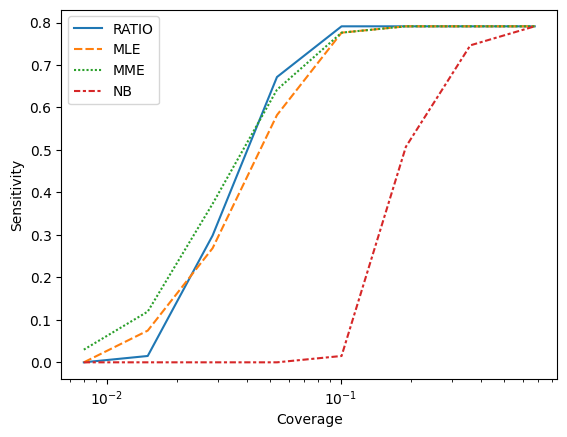

In [17]:
import seaborn
import matplotlib.pyplot as plt

seaborn.lineplot(sensitivity_df.set_index("coverage"))
plt.xscale("log")
plt.xlabel("Coverage")
plt.ylabel("Sensitivity")

In [25]:
coverage_df = pd.DataFrame(coverage_all, columns=["RATIO", "MLE", "MME", "NB"])
coverage_df /= 68
coverage_df["coverage"] = coverages
for i in ["RATIO", "MLE", "MME", "NB"]:
    coverage_df[i] /= coverage_df["coverage"]
coverage_df

,RATIO,MLE,MME,NB,coverage
0,0.985294,0.985294,0.988971,0.985294,0.0080
1,1.016667,1.113725,0.935294,0.985294,0.0150
2,0.968517,1.209300,0.970070,0.985294,0.0284
3,0.739005,0.945712,0.715915,0.985294,0.0535
4,0.485585,0.602359,0.460542,1.064211,0.1010
5,0.387727,0.448429,0.403863,1.703068,0.1902
6,0.312720,0.348408,0.312474,0.478444,0.3585
7,0.284322,0.298869,0.303918,0.394708,0.6757


Text(0, 0.5, 'Relative error in coverage estimation')

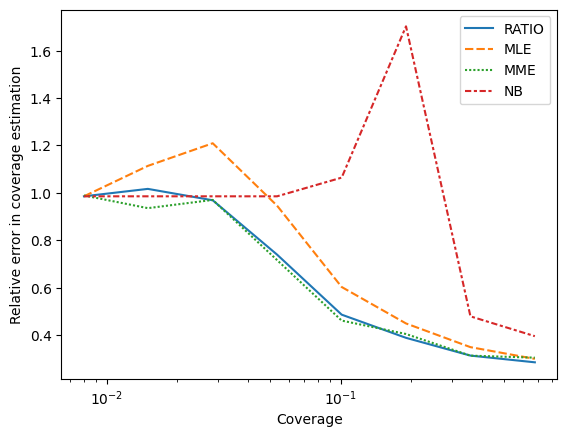

In [27]:
seaborn.lineplot(coverage_df.set_index("coverage"))
plt.xscale("log")
plt.xlabel("Coverage")
plt.ylabel("Relative error in coverage estimation")